# ORIE 5355/INFO 5370 HW 2: Recommendation systems

 - Name: Atmika Pai
 - Net-id: aap253
 - Date: Oct 1, 2024
 - Late days used for this assignment: 0
 - Total late days used (counting this assignment):
 - People with whom you discussed this assignment: 

After you finish the homework, please complete the following (short, anonymous) post-homework survey: https://forms.gle/7tFZUoDszbDeDKmV6 and include the survey completion code below.

### Question 0 [2 points]
<font color='blue'> Survey completion code: hw22022xyz

We have marked questions in <font color='blue'> blue </font>. Please put answers in black (do not change colors). You'll want to write text answers in "markdown" mode instead of code. In Jupyter notebook, you can go to Cell > Cell Type > Markdown, from the menu. Please carefully read the late days policy and grading procedure [here](https://orie5355.github.io/Fall_2021/assignments/). 

# Conceptual component

Go through the "Algorithms tour" [here](https://algorithms-tour.stitchfix.com/). It's a great view of the combination of algorithms used by a modern e-commerce company. 

<font color='blue'> 1) How do they use a combination of "latent" factors and explicit features to gain the benefits of collaborative filtering (matrix factorization) while not being susceptible to cold start issues?

<font color='blue'> 2) How do they match clients with human stylists who make the final decision? Does it remind you of anything we learned in class?



This approach is reminiscent of matching algorithms discussed in classes on recommendation systems or operations research, such as the Hungarian algorithm or other assignment problem solutions. 

<font color='blue'> 3) How do they manage their inventory to ensure that they have enough items that future customers will want?

# Programming component

## Helper code

In [1]:
import numpy as np
import pandas as pd
import os, sys, math
import matplotlib.pyplot as plt
import pickle
def load_pickle(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)
    return data

def load_ratings_and_factors(type_name = 'interaction'):
    ratings = load_pickle('data/{}_ratings'.format(type_name))
    book_vectors = load_pickle('data/{}_dict_book_factor'.format(type_name))
    user_vectors = load_pickle('data/{}_dict_reader_factor'.format(type_name))
    return ratings, book_vectors, user_vectors

In this homework, we are giving you trained user and book item vectors using a GoodReads dataset. Goodreads is a social cataloging website that allows individuals to search its database of books, annotations, quotes, and reviews. There are multiple types of interactions that a user can have with a book: add books to a list of books they intend to read ("short-list" the book), indicate they have read books before, and review books they have read. 

Here, we work with multiple types of interactions as training data for a recommendation system. For each "type" of rating data, we give you the raw ratings data, as well as user and item vectors trained using a Python package (https://berkeley-reclab.github.io/) that implements matrix factorization in cases where there are missing entries in a matrix. The "ratings" data is in a "sparse matrix"/dictionary format, meaning that the dictionary keys are of the kind (user, item), and the dictionary value is the corresponding value. Not all pairs are in the matrix, indicating that that value is missing or at its default value. 

There are 4 types of rating/interaction data:

 - `Interaction`: a "1" indicates the user has interacted with the book at some point in the past, either by saying that they intend to read it, have read it, or have given it a rating. If it is missing, that means the user has not interacted with the book.
 
 - `Explicit Rating`: explicit ratings. Numeric values indicate the ratings given. If it is missing, that means the user has not rated the book.
  
 - `Rating_all_zero`: explicit ratings. Numeric values more than 0 indicate the ratings given. Now, we replace missing values from above with "zeros," so that there are no missing ratings.
 
 - `Rating_interaction_zero`: explicit ratings. Numeric values more than 0 indicate the ratings given. Now, we replace missing values from above with "zeros," only if the user interacted with that book in the past.

In [54]:
ratings_interactions, book_vectors_interactions, user_vectors_interactions = load_ratings_and_factors(type_name = 'interaction')
ratings_explicit, book_vectors_explicit, user_vectors_explicit = load_ratings_and_factors(type_name = 'rating')
ratings_allmissing0, book_vectors_allmissing0, user_vectors_allmissing0 = load_ratings_and_factors(type_name = 'rating_all_zero')
ratings_interact0, book_vectors_interact0, user_vectors_interact0 = load_ratings_and_factors(type_name = 'rating_interaction_zero')


In [55]:
def get_shapes_and_ranges(ratings, book_vectors, item_vectors):
    print(len(ratings), np.shape(book_vectors), np.shape(item_vectors), min(ratings.values()), max(ratings.values()))

In [56]:
get_shapes_and_ranges(ratings_interactions, book_vectors_interactions, user_vectors_interactions)
get_shapes_and_ranges(ratings_explicit, book_vectors_explicit, user_vectors_explicit)
get_shapes_and_ranges(ratings_allmissing0, book_vectors_allmissing0, user_vectors_allmissing0)
get_shapes_and_ranges(ratings_interact0, book_vectors_interact0, user_vectors_interact0)

12238 (200, 10) (1000, 10) 1 1
8324 (200, 10) (1000, 10) 1 5
200000 (200, 10) (1000, 10) 0 5
12238 (200, 10) (1000, 10) 0 5


## Problem 1: Predictions and recommendations with different data types

### 1a) What do different data types mean?

<font color='blue'> What is `Rating_interaction_zero` trying to capture -- why would we fill in books that someone interacted with but did not rate as a 0? (Hint: connect to conceptual reading from HW1). Answer in no more than 3 sentences. 

<font color='blue'> What are some potential problems you see with using `rating_all_zero` for recommendations? Answer in no more than 3 sentences.
    
    

The rating_all_zero doesn't consider whether the user has interacted with the book or not. Therefore, the zero value is misleading if the user has not interacted with the book.

### 1b) Generating predictions

<font color='blue'> Fill in the following function that takes in a user matrix (where each row is 1 user vector) and an item matrix (where each row is 1 item vector), and returns a matrix of predicted ratings for each user and item, where each entry is associated with the corresponding user (row number) and item (column number)

In [150]:
print(user_vectors_interactions.shape)
book_vectors_interactions.shape

(1000, 10)


(200, 10)

In [144]:
def get_predictions(user_vectors, book_vectors):
    return user_vectors @ book_vectors.T

<font color='blue'> Output the predictions for first 10 items for the first user, using each of the 4 data types.

For example, the predictions for one of the data types are:

Ratings for first 10 items,  interactions:
[-0.003  0.01   0.002 -0.001  0.003  0.007 -0.01   0.007  0.001  0.003]

In [145]:
predictions_interactions = get_predictions(user_vectors_interactions, book_vectors_interactions)
predictions_explicit = get_predictions(user_vectors_explicit, book_vectors_explicit)
predictions_allmissing0 = get_predictions(user_vectors_allmissing0, book_vectors_allmissing0)
predictions_interact0 = get_predictions(user_vectors_interact0, book_vectors_interact0)

predictions_interactions[0][:10].round(3)

array([-0.003,  0.01 ,  0.002, -0.001,  0.003,  0.007, -0.01 ,  0.007,
        0.001,  0.003])

<font color='blue'> Do a scatterplot of the predicted rating for the "interaction" and "explicit ratings" types. (Each dot represents one user and one book, with X axis being predicted ratings using interaction data and Y axis being predicted rating using explicit ratings). Describe what you see in no more than 2 sentences. 

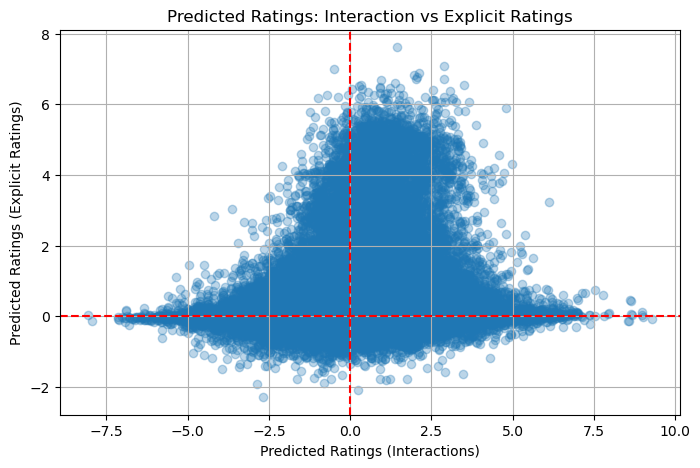

(1000, 200)

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(predictions_interact0, predictions_allmissing0, alpha=0.3)
plt.title('Predicted Ratings: Interaction vs Explicit Ratings')
plt.xlabel('Predicted Ratings (Interactions)')
plt.ylabel('Predicted Ratings (Explicit Ratings)')
plt.axhline(0, color='red', linestyle='--')
plt.axvline(0, color='red', linestyle='--')
plt.grid()
plt.show()
predictions_interactions.shape

The majority of points are clustered densely around the origin and create a parallelogram shape. The spread of points shows a strong positive correlation, though there is noticeable variance, particularly for extreme values, suggesting that predictions from the interaction model and explicit ratings don't always align perfectly.

### 1c) From predictions to recommendations (without capacity constraints)

<font color='blue'> Fill in the following function that takes in the matrix of predicted ratings for each user and item, and returns a dictionary where the keys are the user indices and the values are a list of length "number_top_items" indicating the recommendations given to that user

In [8]:
def get_recommendations_for_each_user(predictions, number_top_items = 10):
    recommendations = {}
    
    for user_idx in range(predictions.shape[0]):
        user_ratings = predictions[user_idx, :]
        top_item_indices = np.argsort(user_ratings)[-number_top_items:][::1]
        recommendations[user_idx] = top_item_indices.tolist()
    return recommendations

<font color='blue'> Output the recommendations for the first user, using each of the 4 data types.

For example, from the "Interaction" dataset, you should get: [182, 198, 19, 100, 104, 73, 30, 199, 164, 74]

In [9]:
recommendations_interactions = get_recommendations_for_each_user(predictions_interactions)
recommendations_explicit = get_recommendations_for_each_user(predictions_explicit)
recommendations_allmissing0 = get_recommendations_for_each_user(predictions_allmissing0)
recommendations_interact0 = get_recommendations_for_each_user(predictions_interact0)

print("Top recommendations for user 0 using interactions:", recommendations_interactions[0]) 
print("Top recommendations for user 0 using explicit_ratings:", recommendations_explicit[0])
print("Top recommendations for user 0 using rating_all_zero :", recommendations_allmissing0[0])
print("Top recommendations for user 0 using rating_interaction_zero:", recommendations_interact0[0])


Top recommendations for user 0 using interactions: [182, 198, 19, 100, 104, 73, 30, 199, 164, 74]
Top recommendations for user 0 using explicit_ratings: [93, 5, 124, 108, 116, 199, 87, 121, 164, 30]
Top recommendations for user 0 using rating_all_zero : [96, 77, 86, 58, 78, 50, 81, 56, 55, 57]
Top recommendations for user 0 using rating_interaction_zero: [52, 73, 37, 182, 74, 170, 111, 1, 53, 166]


<font color='blue'> Fill in the following function that takes in the (top 10) recommendations for each user, and outputs a histogram for how often each item is to be recommended. For example, if there are 18 items, and 10 of them were never recommended, 5 of them were recommended once each, and 3 of them were recommended five times each, then you would have bars at 0, 1, and 5, of height 10, 5, and 3, respectively.

In [68]:
import matplotlib.pyplot as plt

def show_frequency_histograms(recommendations):
    all_recommendations = [item for recs in recommendations.values() for item in recs]
    max_item_id = max(all_recommendations)
    
    item_occurrences = [0] * (max_item_id + 1)
    
    for item in all_recommendations:
        item_occurrences[item] += 1
    
    max_occurrences = max(item_occurrences) 
    frequency_count = [0] * (max_occurrences + 1)
    
    for count in item_occurrences:
        frequency_count[count] += 1  
    
    plt.figure(figsize=(12, 4))
    plt.bar(list(range(len(frequency_count))), frequency_count )
    plt.xlabel('Number of times an item is recommended')
    plt.ylabel('Number of items')
    plt.title('Histogram of Item Recommendation Frequency')
    plt.show()

<font color='blue'> Show the histograms for the "interact" and "explicit" data types. Describe what you observe in no more than 3 sentences. For example, discuss how often is the most recommended item recommended, how that compares to the least recommended items, and what that could mean for recommendations in various contexts. 

Recommendations_interactions:


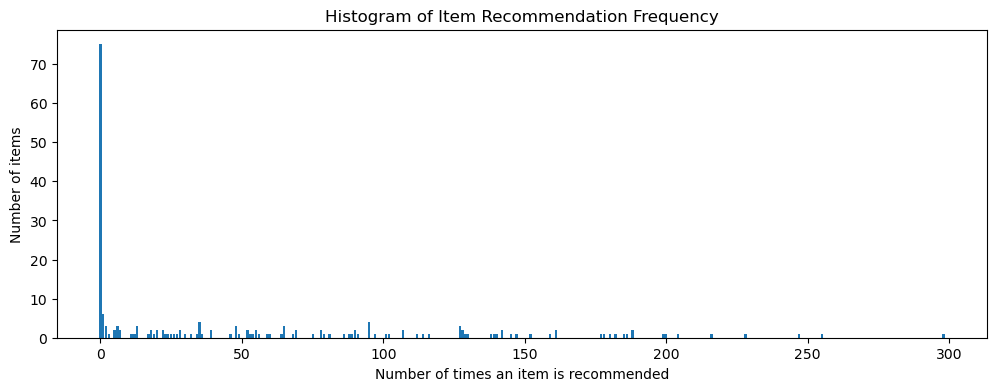

Recommendations_explicit:


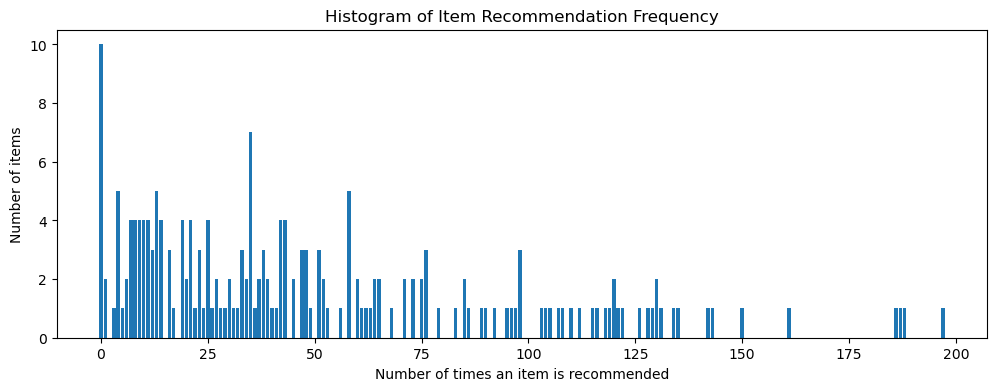

In [69]:
print("Recommendations_interactions:")
show_frequency_histograms(recommendations_interactions)
print("Recommendations_explicit:")
show_frequency_histograms(recommendations_explicit)


The histogram for "Recommendations_interactions" shows a highly skewed distribution, with the most recommended item appearing around 300 times and 70+ items are recommended 0 times. 

In contrast, the "Recommendations_explicit" histogram is more evenly distributed, with many items being recommended between 1 and 50 times and < 10 items recommended 0 times. This indicates that explicit recommendations are more diverse, offering a wider range of selections to users.

# Problem 2: Cold start -- recommendations for new users

In this part of the assignment, we are going to ask you to tackle the "cold-start" problem with matrix-factorization based recommendation systems. The above recommendation techniques worked when you had access to past data for reach user, such as interactions or explicit ratings. However, it doesn't work as well when a new user has just joined the platform and so the platform doesn't have any data.  

You should also see a comma-separated values file (user_demographics.csv) that contains basic demographic information on each user. Each row describes one user, and have four attributes: 'User ID', 'Wealth', 'Age group' and 'Location'.

User ID is the unique identifier associated with each user, and it is in the same order as the user_vectors, and in the same indexing as the ratings (be careful about 0 and 1 indexing in Python).

Wealth is a non-negative, normalized value indicating the average wealth of the neighborhood in which the user is, where we normalized it such that each Location has similar wealth distributions. Age group describes the age of the user. Location describes the region that the user is from.

In [12]:
demographics = pd.read_csv("data/user_demographics.csv")
demographics.head()

,User ID,Wealth,Age group,Location
0,1,1.833101,50 to 64,America
1,2,2.194996,18 to 34,America
2,3,2.216195,18 to 34,Europe
3,4,0.838690,50 to 64,Asia Pacific
4,5,2.109313,18 to 34,America


We are now going to pretend that we don't have the personalized ratings/interactions history for the last 100 users, and thus don't have their user vectors. Rather, let's pretend that these are new users to the platform, and you are able to get the above demographics from their browswer cookies/IP address. Now, we're going to try to recommend items for them anyway. For this part, we'll exclusively use the "ratings with interaction0" data.

In [13]:
existing_user_vectors = user_vectors_interact0[0:900,:]
existing_user_demographics = demographics.iloc[0:900,:]
new_user_demographics = demographics.iloc[900:,:]

### 2a) Predictions for new users [Simple]

<font color='blue'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='blue'> For this question, we ask you to use the following simple method to construct the vector for the new user. Each user is classified as "Low" or "High" wealth based on whether their Wealth score is below or above the median of 1.70. Then, we simply construct a mean user vector for "Low" and "High" wealth, based on the 900 users (take the average vector among users with "Low" and "High" Wealth, respectively.). The corresponding mean vector is then used for each new user. 

For example, using this method, you should find that the vector for the second user (index "1") is:

array([-0.183, -0.149, -0.141, -0.199, -0.166, -0.272, -0.02 ,  0.137,
       -0.12 ,  0.022])

In [14]:
existing_user_demographics.Wealth.median()

1.7026180771992308

In [15]:
def get_user_vector_for_new_user(new_user, existing_user_demographics, existing_user_vectors):
    wealth_median = existing_user_demographics.Wealth.median()
    
    low_wealth_users = existing_user_vectors[existing_user_demographics.Wealth < wealth_median]
    high_wealth_users = existing_user_vectors[existing_user_demographics.Wealth >= wealth_median]
    
    mean_low_wealth = np.mean(low_wealth_users, axis=0)
    mean_high_wealth = np.mean(high_wealth_users, axis=0)
    
    if new_user['Wealth'] < wealth_median:
        return mean_low_wealth
    else:
        return mean_high_wealth

In [16]:
#vector for second user (index 1)
get_user_vector_for_new_user(new_user_demographics.iloc[1, :], 
                             existing_user_demographics, 
                             existing_user_vectors).round(3)

array([-0.183, -0.149, -0.141, -0.199, -0.166, -0.272, -0.02 ,  0.137,
       -0.12 ,  0.022])

<font color='blue'> Output the mean vector predicted for the first user (index 0) in `new_user_demographics`. 

In [95]:
get_user_vector_for_new_user(new_user_demographics.iloc[0, :], 
                             existing_user_demographics, 
                             existing_user_vectors).round(3)


array([ 0.088, -0.207, -0.178, -0.131, -0.089, -0.127, -0.122, -0.427,
       -0.058, -0.106])

### 2b) [Bonus, 3 points] Predictions for new users [Using KNN or another model]

<font color='blue'> Fill in the following function that takes in: the demographics of a single new user, the demographics of all the existing users in your platform, and the user vectors of all the existing users, and outputs a 'predicted' user vector for the new user to use until we get enough data for that user. 
    
<font color='blue'> Now, use K nearest neighbors or some other machine learning method. 
    
<font color='blue'> Feel free to prepare data/train a model outside this function, and then use your trained model within the function.

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#preprocessing

age_mapping = {
    '18 to 34': 26,  
    '35 to 49': 42,
    '50 to 64': 57,
    '65+': 70
}

def preprocessing(X):
    X['AgeRangeNumeric'] = X['Age group'].map(age_mapping)
    X = X.drop(columns='Age group')
    scaler = MinMaxScaler()
    X['AgeRangeNumeric'] = scaler.fit_transform(X[['AgeRangeNumeric']])
    df_one_hot = pd.get_dummies(X['Location'], prefix='Location').astype(int)
    merged_df = pd.merge(X, df_one_hot, 
                     left_index = True, 
                     right_index = True)
    merged_df = merged_df.drop(columns='Location').dropna()
    
    return merged_df

In [19]:
X = preprocessing(existing_user_demographics[["Wealth", "Age group", "Location"]])

merged_df = pd.merge(X, pd.DataFrame(existing_user_vectors), 
                     left_index = True, 
                     right_index = True)

merged_df.head()

,Wealth,AgeRangeNumeric,Location_Africa,Location_America,Location_Asia Pacific,Location_Europe,0,1,2,3,4,5,6,7,8,9
0,1.833101,1.0,0,1,0,0,0.044650,1.516071,0.386676,-0.231313,0.010979,-0.777386,-0.918934,-1.738276,-0.676126,-0.664088
1,2.194996,0.0,0,1,0,0,-0.169997,-0.445367,0.038597,0.639181,-1.004104,-0.003821,0.594562,-0.640097,-1.133117,-0.755225
2,2.216195,0.0,0,0,0,1,-0.540653,-0.596771,0.355966,-0.340564,-0.077922,-0.245096,-0.356673,1.402198,-0.924730,-0.184581
3,0.838690,1.0,0,0,1,0,0.726120,-0.025440,-0.088755,-0.466002,-0.415205,0.371652,-0.766541,-0.494964,-1.071265,0.800885
4,2.109313,0.0,0,1,0,0,0.272964,-0.352270,-0.453036,0.236451,0.448951,-0.031348,-0.558717,0.380273,0.401688,0.646854


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X = merged_df.iloc[:, 0:6]
y = merged_df.iloc[:, 7:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

k = 60
knn = KNeighborsRegressor(n_neighbors=k, metric='l2')
knn.fit(X, y)
y_pred = knn.predict(X_test)

print("L2 Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred, multioutput='uniform_average'))
print("L2 R^2 Score:", r2_score(y_test, y_pred, multioutput='uniform_average'))


knn = KNeighborsRegressor(n_neighbors=k, metric='l1')
knn.fit(X, y)
y_pred = knn.predict(X_test)

print("L1 Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred, multioutput='uniform_average'))
print("L1 R^2 Score:", r2_score(y_test, y_pred, multioutput='uniform_average'))



L2 Mean Squared Error (MSE): 0.40367642701188966
L2 R^2 Score: 0.08561573322158017
L1 Mean Squared Error (MSE): 0.4042485045440747
L1 R^2 Score: 0.08493325124621492


In [21]:
def get_user_vector_for_new_user_knn(new_user, existing_user_demographics, existing_user_vectors):
    new_user2 = preprocessing(pd.DataFrame(new_user).drop(columns='User ID'))
    
    existing_user_demographics2 = preprocessing(existing_user_demographics[["Wealth", "Age group", "Location"]])
    merged_df = pd.merge(X, existing_user_demographics2, 
                     left_index = True, 
                     right_index = True)
    X = merged_df.iloc[:, 0:6]
    y = merged_df.iloc[:, 7:]
    
    knn = KNeighborsRegressor(n_neighbors=k, metric='l2')

    knn.fit(X, y)
    y_pred = knn.predict(new_user2)
    return y_pred

<font color='blue'> Justify your choice of model. If you used K nearest neighbors, then how did you decide upon your distance function? If you used another model, how does that model weight the different demographics in importance (either implicitly or explicitly)?

L2 norm (Euclidean distance) had a slightly higher R^2 than L1 norm, so I decided to go with the euclidean distance.

### 2c) Comparing predictions from "true" user vector and from above

<font color='blue'> For each of the 100 "new" users, use either your model from 2a or 2b ("demographic model") to retrieve a user vector for that user, and then your functions from Problem 1 to get predicted ratings and top-10 recommendations. First, plot a scatterplot between the ratings predicted by the demographic model and the ratings predicted by the full model from Problem 1. Each point in the scatter plot should correspond to one user and one item, and so your scatterplot should have 100*200 points.  

For example, for the first user-item pair (index 0 user, index 0 user), your prediction using the basic demographic should be -0.0011902780252621872, and using the full model should be 0.31447640890118356. So one point in the scatter plot would be (-0.0011902780252621872, 0.31447640890118356).

In [22]:
#Retrieving user vector for new users 
predicted_user_vectors = []

for i in np.arange(0, 100, 1):
    hello = get_user_vector_for_new_user(new_user_demographics.iloc[i, :], 
                             existing_user_demographics, 
                             existing_user_vectors)
    
    predicted_user_vectors.append(hello)

predicted_user_vectors = np.array(predicted_user_vectors)
predicted_user_vectors[0][0]

0.08780943150811217

In [23]:
predictions = get_predictions(user_vectors_interact0[0:900,:], 
                              book_vectors_interact0[0:900,:])

predictions[0][0]
#get_recommendations_for_each_user(predictions, number_top_items = 10)

-1.0087931147516576

<font color='blue'> Now for each new user, calculate the mean rating (according to the "full" model in Problem 1) for the 10 items recommended to that user, by each of the demopgraphic and "full" models. Output a scatterplot for the two mean ratings, where each point correpsonds to 1 user (and so you will have 100 points in your scatter plot). For example, for the first new user, the associated point is (2.4880867541832146, 0.5305243424156764). 

<font color='blue'> Comment on the above. What is the "loss" from using demographics since we do not have access to the full data?

# Problem 3: Predictions under capacity constraints

Above, you should have observed that if we just recommend the top items for each user, some items get recommended quite a bit, and many items do not get recommended at all. Here, we are going to ask you to implement recommendations under capacity constraints.

Throughout this part, assume that you only have 5 copies of each item that you recommend, and that you will only recommend 1 item to each user. In other words, you cannot recommend the same item more than 5 times, and so there are exactly 1000 items in stock (representing 200 unique books) for your 1000 users. 

We'll continue exclusively using the "ratings with interaction0" data.

Now, let's assume that users are entering the platform sequentially in order of index. So the index 0 user comes first, index 1 user comes second, etc. 

### 3a) Naive recommendations under capacity constraints

<font color='blue'> First, let's pretend that we were naively recommending the predicted favorite item to each user. Of course, with unlimited capacity, each user would be recommended their predicted favorite. With capacity constraints, the favorite items of the users who come in later might already have reached their capacity, and so they have to be recommended an item further down their list. 
    
<font color='blue'> Do the following: simulate users coming in sequentially, in order of index. For each user, recommend to them their predicted favorite item that is still available. So the first user will get their favorite item, but the last few users will almost certainly not receive any of their top few predicted items. For each user, keep track of what the rank of the item that they were ultimately recommended was, according to the predicting ranking over items for that user.
    
For example, you'll see that the first user was recommended their favorite item, but the last user was recommended their 129th favorite item. 


<font color='blue'> Plot the resulting rankings in 2 ways: 1) A line plot, where the X axis is the user index and the Y axis is the rank of the item that they were recommended. and 2) A histogram of how often each rank shows up. (the X axis is the (binned) rank, and the Y axis is the count of that bin). 

In [105]:
predictions = predictions_interact0
num_users, num_items = predictions.shape
num_items


200

In [142]:
#
#item_recommendation count: keeps track of how many times item was recommended to meet capacity constraints
#recommendations

def recommendation_capacity_constraint(predictions, capacity=5):
    num_users, num_items = predictions.shape
    item_recommendation_count = {i: 0 for i in range(num_items)}
    recommendations = []
    ranks = []

    for user in np.arange(0, num_users, 1):
        user_predictions = predictions[user]
        sorted_items = np.argsort(-user_predictions)
        
        for item in sorted_items:
            if item_recommendation_count[item] < capacity:
                recommendations.append(item)
                item_recommendation_count[item] = item_recommendation_count[item]+1
                rank = np.where(sorted_items == item)[0][0] + 1
                ranks.append(rank)
                break

    return recommendations, ranks, item_recommendation_count

recommended_items, item_ranks, item_recommendation_count = recommendation_capacity_constraint(predictions_interact0)

##all items recommended 5 times
print(all(x == 5 for x in item_recommendation_count.values()))


True


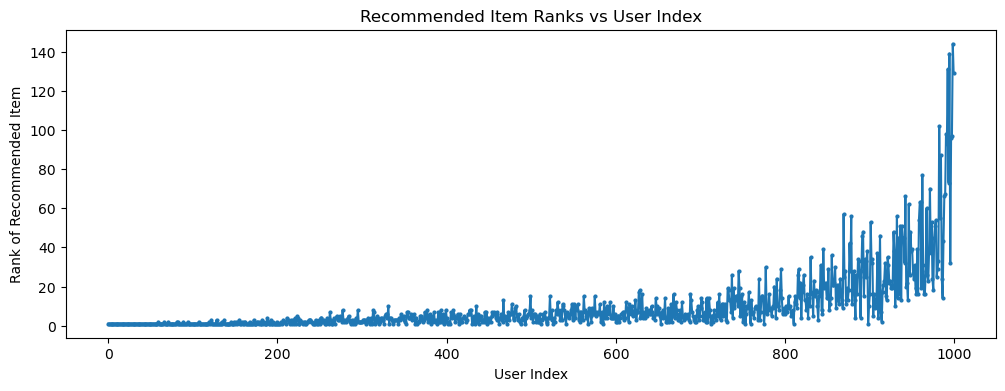

In [111]:
#Graph 1
plt.figure(figsize=(12, 4))
plt.plot(range(len(item_ranks)), item_ranks, 
         marker='o', linestyle='-', markersize=2)
plt.title('Recommended Item Ranks vs User Index')
plt.xlabel('User Index')
plt.ylabel('Rank of Recommended Item')
plt.show()

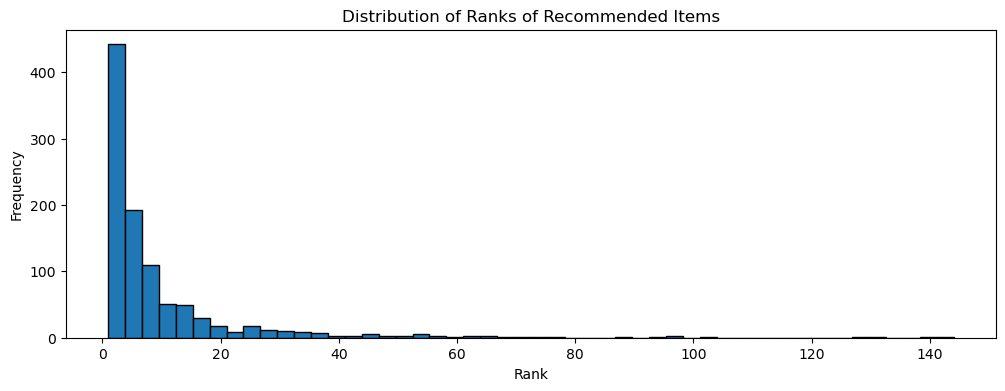

In [48]:
#Graph 2

plt.figure(figsize=(12, 4))
plt.hist([rank for rank in item_ranks if rank is not None], bins=50, edgecolor='black')
plt.title("Distribution of Ranks of Recommended Items")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.show()

### 3b) [Bonus -- 4 pts] Optimal recommendations under capacity constraints -- maximum weight matching

[2 points] <font color='blue'> Now let's do "optimal" recommendations with capacity, using maximum weight matching. Create the same two plots as above. <font color='blue'> Describe what you observe compared to the naive recommendations above. 
    
<font color='blue'>We suggest you use the `scipy.optimize.linear_sum_assignment` function. In that case, `np.tile` might also come in handy to create 5 copies of each items.  

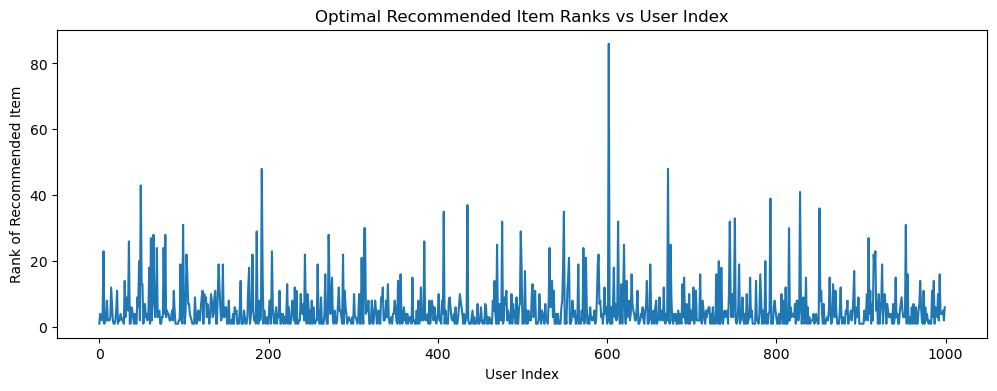

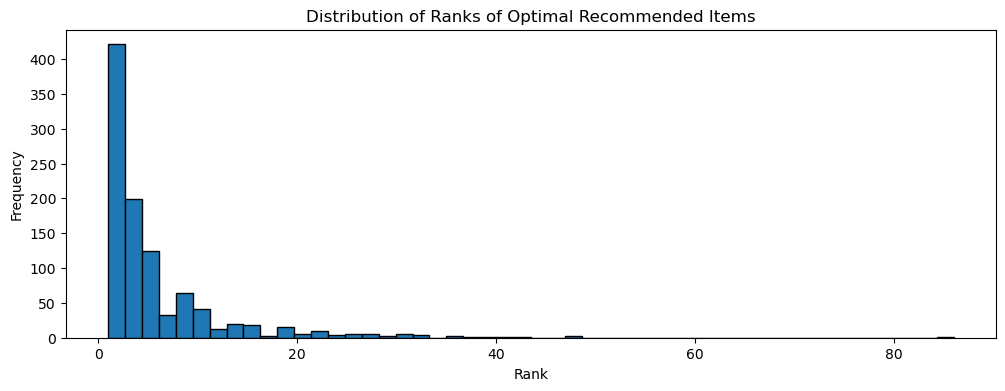

In [72]:
from scipy.optimize import linear_sum_assignment

def optimal_recommendations_with_capacity(predictions, capacity=5):
    num_users, num_items = predictions.shape
    
    expanded_predictions = np.tile(predictions, (1, capacity))
    row_ind, col_ind = linear_sum_assignment(-expanded_predictions)
    
    recommended_items = col_ind % num_items

    ranks = []
    for user, item in enumerate(recommended_items):
        user_predictions = predictions[user]
        sorted_items = np.argsort(user_predictions)[::-1]
        rank = np.where(sorted_items == item)[0][0] + 1
        ranks.append(rank)
    
    return recommended_items, ranks


optimal_items, optimal_ranks = optimal_recommendations_with_capacity(predictions_interact0)

plt.figure(figsize=(12, 4))
plt.plot(range(len(optimal_ranks)), optimal_ranks)
plt.title('Optimal Recommended Item Ranks vs User Index')
plt.xlabel('User Index')
plt.ylabel('Rank of Recommended Item')
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(optimal_ranks, bins=50, edgecolor='black')
plt.title("Distribution of Ranks of Optimal Recommended Items")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.show()


[2 points] <font color='blue'> Of course, in reality you don't observe all the users at the same time -- they come in one by one, and you need to create a recommendation for the first user before the 50th user shows up. Here's let's pretend that users show up in batches of 100. So the first 100 users at the same time, next 100, etc. In this case, you can do "batched maximum weight matching," where you run maximum weight matching for the first 100 together to determine recommendations. Then, you do the same thing for the next 100 users with the items that are remaining, etc. 
    
<font color='blue'> Implement the above, show the same two plots as above, and describe what you observe. Note that this part requires careful attention for how many of each item remain after each round. 

In [43]:
def batched_maximum_weight_matching(predictions, batch_size=100, capacity=5):
    num_users, num_items = predictions.shape
    recommended_items = []
    ranks = []
    remaining_capacity = np.full(num_items, capacity)

    for batch_start in range(0, num_users, batch_size):
        batch_end = min(batch_start + batch_size, num_users)
        batch_predictions = predictions[batch_start:batch_end]
        
        expanded_predictions = np.repeat(batch_predictions, remaining_capacity, axis=1)
        
        row_ind, col_ind = linear_sum_assignment(-expanded_predictions)
        
        for batch_user, item_index in zip(row_ind, col_ind):
            cumsum = np.cumsum(remaining_capacity)
            original_item = np.searchsorted(cumsum, item_index + 1)
            if original_item >= num_items:
                original_item = num_items - 1
            
            recommended_items.append(original_item)
            remaining_capacity[original_item] = max(0, remaining_capacity[original_item] - 1)
            
            user_index = batch_start + batch_user
            user_predictions = predictions[user_index]
            sorted_items = np.argsort(user_predictions)[::-1]
            rank = np.where(sorted_items == original_item)[0][0] + 1
            ranks.append(rank)

    return recommended_items, ranks

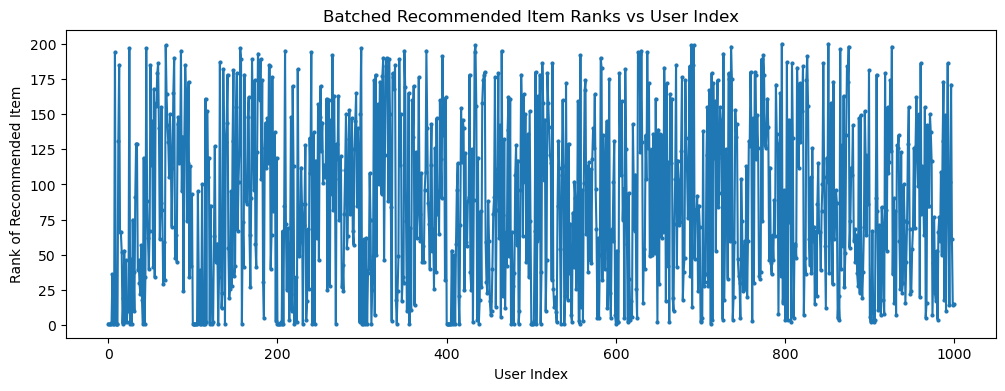

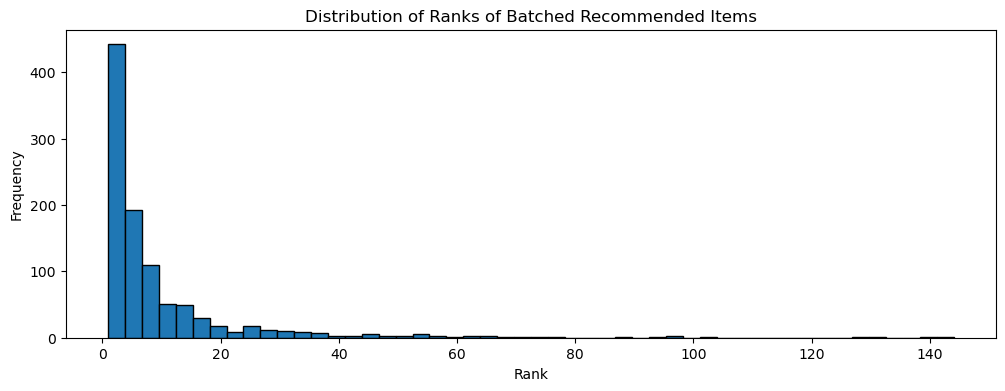

In [46]:
batched_items, batched_ranks = batched_maximum_weight_matching(predictions_interact0)

plt.figure(figsize=(12, 4))
plt.plot(range(len(batched_ranks)), batched_ranks, marker='o', linestyle='-', markersize=2)
plt.title('Batched Recommended Item Ranks vs User Index')
plt.xlabel('User Index')
plt.ylabel('Rank of Recommended Item')
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(item_ranks, bins=50, edgecolor='black')
plt.title('Distribution of Ranks of Batched Recommended Items')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()


### 3c) Score functions for recommendations under capacity constraints

<font color='blue'>Here, we are working with just 200 items and 1000 users, and so batched maximum weight matching is feasible to run. In practice, with millions of items, that  might not be an effective strategy. Now, we ask you to implement the score function approach from class.

<font color='blue'> You should normalize the predicted ratings between 0 and 1 so that you are not dividing by a negative or close to 0 average rating before proceeding.
    
<font color='blue'> Implement the above and run the same simulation as part 3c, show the same two plots, and describe what you observe.

<font color='blue'> For this part, use the following score function:
    
$$\frac{r_{ij}}{\bar{r_{j}}} \sqrt{C_j} $$

HINT: In your code, for each user $i$ you will:
1. Retrieve the ratings ${r_{ij}}$ for each item $j$. 
2. Normalize each  ${r_{ij}}$ for by mean item rating $r_j$ and multiply by the sqrt of the current capacity for that item. 
3. Sort the items by the above modified score, and recommend the best item according to the modified score.

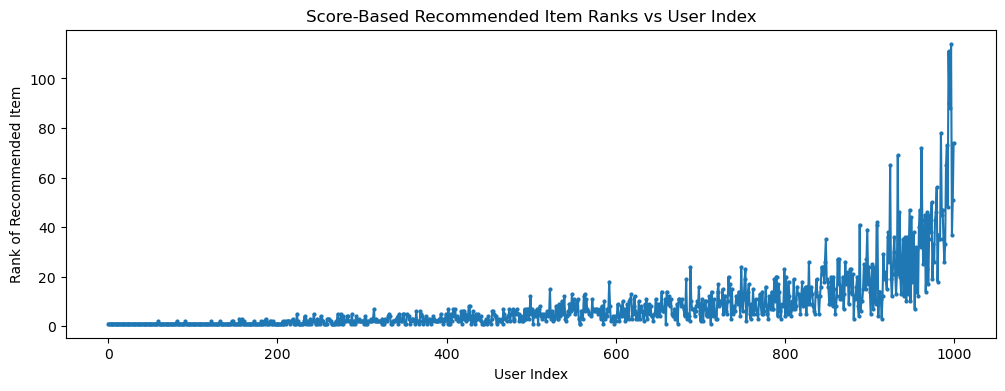

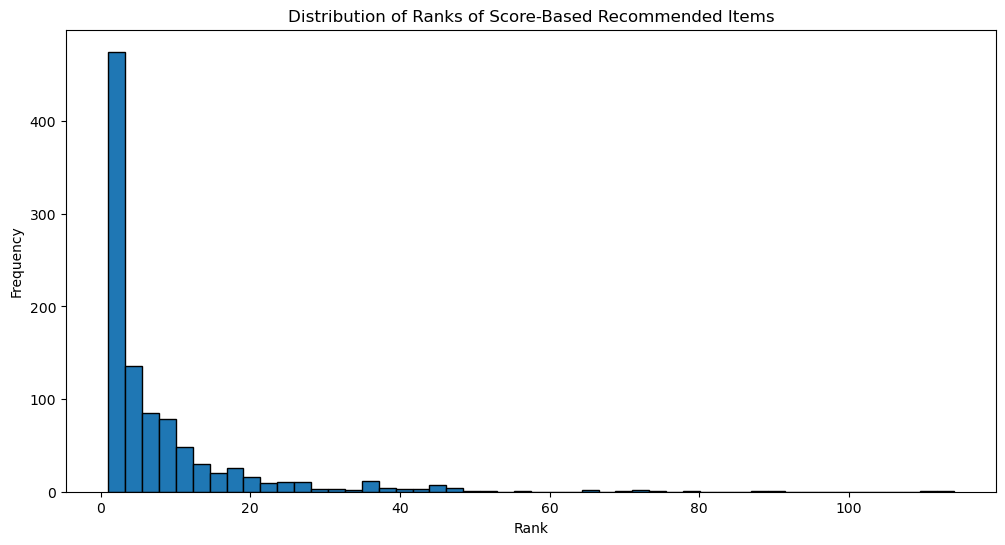

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_predictions(predictions):
    min_val = predictions.min()
    max_val = predictions.max()
    return (predictions - min_val) / (max_val - min_val)

def calculate_scores(predictions, capacities):
    num_users, num_items = predictions.shape
    scores = np.zeros_like(predictions)
    
    # Calculate mean item ratings
    mean_item_ratings = predictions.mean(axis=0)
    
    for i in range(num_users):
        for j in range(num_items):
            if capacities[j] > 0:
                scores[i, j] = (predictions[i, j] / mean_item_ratings[j]) * np.sqrt(capacities[j])
    
    return scores

def recommend_items(scores, capacities):
    num_users = scores.shape[0]
    recommended_items = []
    ranks = []
    
    for i in range(num_users):
        sorted_indices = np.argsort(scores[i])[::-1]
        for idx in sorted_indices:
            if capacities[idx] > 0:
                recommended_items.append(idx)
                capacities[idx] -= 1
                rank = np.where(sorted_indices == idx)[0][0] + 1
                ranks.append(rank)
                break
    
    return recommended_items, ranks


normalized_predictions = normalize_predictions(predictions_interact0)
capacities = np.full(predictions_interact0.shape[1], 5)
scores = calculate_scores(normalized_predictions, capacities)
recommended_items, item_ranks = recommend_items(scores, capacities)

plt.figure(figsize=(12, 4))
plt.plot(range(len(item_ranks)), item_ranks, marker='o', linestyle='-', markersize=2)
plt.title('Score-Based Recommended Item Ranks vs User Index')
plt.xlabel('User Index')
plt.ylabel('Rank of Recommended Item')
plt.show()


plt.figure(figsize=(12, 6))
plt.hist(item_ranks, bins=50, edgecolor='black')
plt.title('Distribution of Ranks of Score-Based Recommended Items')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()


Comment for entire homework: In this homework, we haven't been careful with what is "training" data and what is "test" data. For example, in 3c, you're using average ratings from customers who haven't shown up yet in your simulation. In Problem 2, when training the user/book vectors we used data from customers that we are then pretending we haven't seen data from. In practice, and for the class project, you should be more careful. Such train/test/validation pipelines should be a core part of what you learn in machine learning classes. 